<a href="https://colab.research.google.com/github/trypanosomatics/yeast_repo_pipeline/blob/main/lys_inhibitors_comparasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook overview

This notebook presents a structural comparison of selected small molecules using RDKit-based twe and three-dimensional representations. The workflow is organized to provide a progressive visualization of the compounds, starting from individual molecular structures and moving toward pairwise and multi-compound superpositions.

First, all compounds included in the analysis are visualized individually to provide an overview of their chemical structures and conformations. These representations allow inspection of overall molecular shape, functional group distribution, and stereochemistry prior to any alignment.

Pairwise atom-level comparisons were performed using GetSimilarityMapForFingerprint, which highlights the contributions of individual atoms and substructures to the overall molecular similarity.

Fingerprint-based similarity metrics, including the Tanimoto and Braun‑Blanquet coefficients, were also calculated to quantify two-dimensional feature overlap between molecules. Tanimoto measures the proportion of shared features relative to the union of features, while Braun‑Blanquet emphasizes the maximum overlap.

The following table provides a guideline for interpreting Tanimoto and Braun‑Blanquet values:

| Similarity Value | Interpretation           | Description of 2D Feature Overlap                                            |
| ---------------- | ------------------------ | ---------------------------------------------------------------------------- |
| ≥ 0.75           | High similarity          | Most substructures shared; molecules are closely related                     |
| 0.60–0.74        | Moderate–high similarity | Substantial shared features with minor differences                           |
| 0.45–0.59        | Moderate similarity      | Partial overlap; core scaffolds may be conserved with divergent substituents |
| < 0.45           | Low similarity           | Limited shared features; distinct chemical scaffolds                         |

Next, pairwise shape-based alignments are performed using the O3A (Optimal 3D Alignment) method, with CID12 used as the reference molecule. Each comparison is displayed using a consistent color scheme to facilitate visual interpretation and direct comparison across compounds. Shape similarity is quantified using the Tversky index, which is can be printed if needed alongside each alignment.

The Tversky index is a shape-based similarity metric that quantifies the degree of three-dimensional overlap between two molecules after alignment. In the context of RDKit shape comparisons, it is commonly used to assess how well the volume of one molecule matches that of another, with tunable asymmetry depending on which molecule is treated as the reference.

| Tversky index | Interpretation            | Description of shape overlap                          |
|---------------|---------------------------|--------------------------------------------------------|
| ≥ 0.75        | High similarity           | Strong 3D volumetric overlap; very similar global shape |
| 0.60–0.74     | Moderate–high similarity  | Substantial overlap with minor structural differences   |
| 0.45–0.59     | Moderate similarity       | Partial overlap; shared core with divergent regions     |
| < 0.45        | Low similarity            | Limited overlap; distinct overall shapes                |

Finally, all compounds are superimposed in a single 3D view while maintaining their assigned colors. This combined visualization highlights shared and divergent structural features across the full set of molecules and provides an integrated perspective on shape similarity and spatial overlap.


In [1]:
# @title Install and import

!pip install rdkit py3Dmol jCompoundMapper_pywrapper

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import rdkit
print(rdkit.__version__)

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, rdMolAlign, rdMolTransforms, rdShapeAlign, rdShapeHelpers
from rdkit.Chem.Draw import IPythonConsole, SimilarityMaps
from rdkit.DataStructs.cDataStructs import ExplicitBitVect, CreateFromBitString, BraunBlanquetSimilarity

from jCompoundMapper_pywrapper import JCompoundMapper

IPythonConsole.ipython_3d = True
from IPython.display import Image, display

import py3Dmol

plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'
%matplotlib inline

%load_ext sql
%config SqlMagic.feedback=0


2025.09.3


In [37]:
# Molecules
smiles_dict = {
    "CID12" : "OC1=CC=C2C(=O)C(=COC2=C1)C1=C(Cl)C=CC=C1",
    "Cladosporin" : "C[C@H]1CCC[C@@H](O1)C[C@H]2CC3=C(C(=CC(=C3)O)O)C(=O)O2",
    "DDD508" : "C1(O)C=CC2OC(C(=O)NCC3(O)CCCCC3)=CC(=O)C=2C=1",
    "DDD489" : "N1C(N)=NC2CN(CC3C[C@@H](C(F)(F)F)CCC3)C(=O)C=2C=1C(F)(F)F",
    "DDD02049209" : "N1C(N)=NC2C[C@H](N3C(F)(F)CCCC[C@@H]3O)C(=O)C=2C=1OC",
    "DMU371" : "CC1=NC2=C(C(N)=N1)C(F)=C(F)C(NC1CCCC1)=C2F",
    "DMU759" : "CC1=NC2=C(C(N)=N1)C(F)=C(F)C(SC1CCCCC1)=C2F"
}

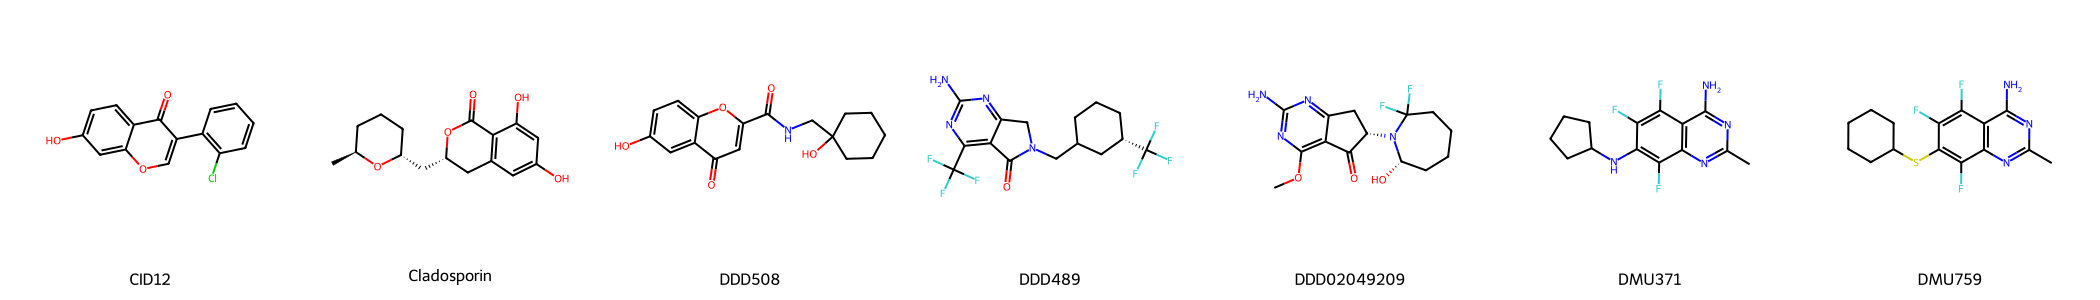

In [38]:
# @title Show molecules in 2D

mols_2d = []
legends = []

for name, smi in smiles_dict.items():
    mol = Chem.MolFromSmiles(smi)
    Chem.rdDepictor.Compute2DCoords(mol)
    mols_2d.append(mol)
    legends.append(name)

img = Draw.MolsToGridImage(
    mols_2d,
    molsPerRow=7,
    subImgSize=(300, 300),
    legends=legends
)

img

Cladosporin vs CID12


[20:49:37] DEPRECATION WARNING: please use MorganGenerator
[20:49:37] DEPRECATION WARNING: please use MorganGenerator


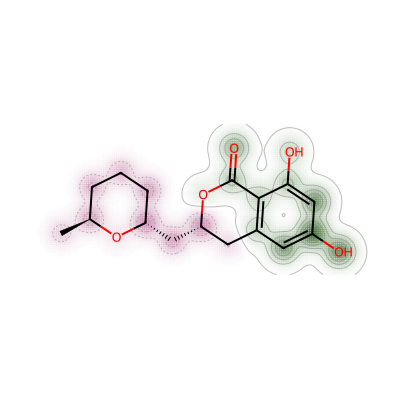

DDD508 vs CID12


[20:49:37] DEPRECATION WARNING: please use MorganGenerator
[20:49:37] DEPRECATION WARNING: please use MorganGenerator


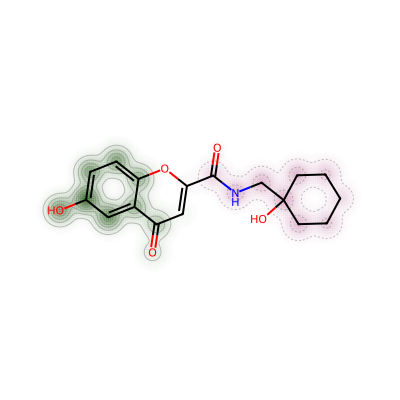

DDD489 vs CID12


[20:49:37] DEPRECATION WARNING: please use MorganGenerator
[20:49:37] DEPRECATION WARNING: please use MorganGenerator


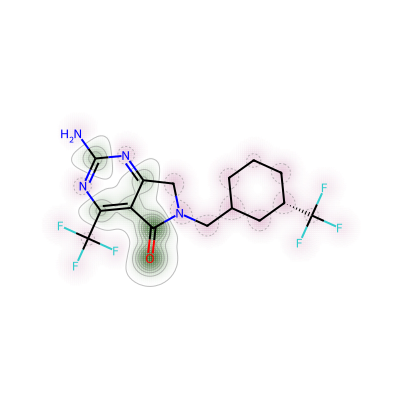

[20:49:37] DEPRECATION WARNING: please use MorganGenerator
[20:49:37] DEPRECATION WARNING: please use MorganGenerator


DDD02049209 vs CID12


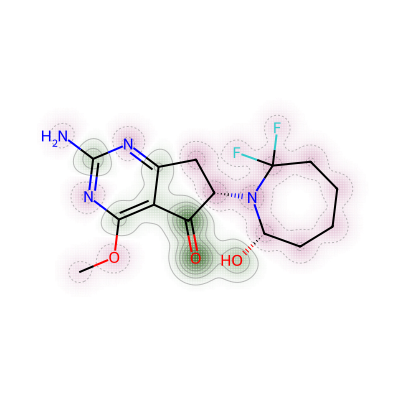

[20:49:38] DEPRECATION WARNING: please use MorganGenerator
[20:49:38] DEPRECATION WARNING: please use MorganGenerator


DMU371 vs CID12


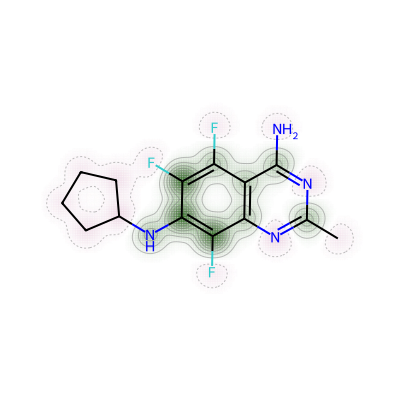

[20:49:38] DEPRECATION WARNING: please use MorganGenerator
[20:49:38] DEPRECATION WARNING: please use MorganGenerator


DMU759 vs CID12


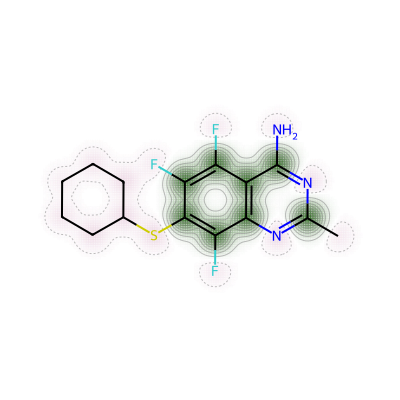

In [39]:
# @title Pairwise atom-level comparisons

# Reference molecule
ref_smiles = smiles_dict["CID12"]
ref_mol = Chem.MolFromSmiles(ref_smiles)

# Loop over all molecules except CID12
for name, smi in smiles_dict.items():
    if name == "CID12":
        continue

    mol = Chem.MolFromSmiles(smi)

    # Create a 2D similarity map
    d2d = Draw.MolDraw2DCairo(400, 400)
    _, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(ref_mol, mol, SimilarityMaps.GetMorganFingerprint, d2d)

    d2d.FinishDrawing()
    img = d2d.GetDrawingText()

    print(f"{name} vs CID12")
    display(Image(img))

In [40]:
# @title Calculate Tanimoto and Braun–Blanquet
def list_to_explicit_bit_vect(fp_list):
    bitstring = "".join(str(int(b)) for b in fp_list)
    return CreateFromBitString(bitstring)

def explicitbitvect_to_list(fp_vect: ExplicitBitVect) -> list[int]:
    return [1 if fp_vect.GetBit(i) else 0 for i in range(fp_vect.GetNumBits())]

def braun_blanquet_numpy(fp1, fp2):
    a = np.array(fp1, dtype=bool)
    b = np.array(fp2, dtype=bool)
    c = np.logical_and(a, b).sum()
    return c / max(a.sum(), b.sum()) if max(a.sum(), b.sum()) > 0 else 0.0

mols = {name: Chem.MolFromSmiles(smi) for name, smi in smiles_dict.items()}

fps_morgan = {name: AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
              for name, mol in mols.items()}

ref_name = "CID12"
sim_dict_tanimoto = {}
for name, fp in fps_morgan.items():
    if name != ref_name:
        sim_dict_tanimoto[name] = DataStructs.TanimotoSimilarity(fps_morgan[ref_name], fp)

jcm = JCompoundMapper("ASP")
fps_raw = jcm.calculate(list(mols.values()))
fps_lists = [fps_raw.loc[idx, :].tolist() for idx in fps_raw.index]

asp_fps = dict(zip(mols.keys(), fps_lists))


[20:49:38] DEPRECATION WARNING: please use MorganGenerator
[20:49:38] DEPRECATION WARNING: please use MorganGenerator
[20:49:38] DEPRECATION WARNING: please use MorganGenerator
[20:49:38] DEPRECATION WARNING: please use MorganGenerator
[20:49:38] DEPRECATION WARNING: please use MorganGenerator
[20:49:38] DEPRECATION WARNING: please use MorganGenerator
[20:49:38] DEPRECATION WARNING: please use MorganGenerator
/usr/local/lib/python3.12/dist-packages/jCompoundMapper_pywrapper/jcompoundmapper.py:202: UserWarning: Molecule lacks hydrogen atoms: this might affect the value of calculated fingerprint
  warnings.warn('Molecule lacks hydrogen atoms: this might affect the value of calculated fingerprint')


Fingerprinting algorithms for your use.
jCompoundMapper provides popular fingerprinting algorithms for chemical graphs such as
depth-first search fingerprints, shortest-path fingerprints, extended connectivity fingerprints,
autocorrelation fingerprints (e.g. CATS2D), radial fingerprints (e.g. Molprint2D), geometrical
Molprint, atom pairs, and pharmacophore fingerprints.

###################################

Should you publish results based on the jCompoundMapper fingerprints, please cite:

jCompoundMapper: An open source Java library and command-line tool for chemical fingerprints.
Hinselmann, G., Rosenbaum, L., Jahn, A., Fechner N., and Zeel A.
Journal of Cheminformatics 2003  3 (3).
DOI: 10.1186/1758-2946-3-3

###################################




In [41]:
# @title Tanimoto and Braun-Blanquet scores
sim_dict_bb = {}
fp_ref = asp_fps[ref_name]
for name, fp in asp_fps.items():
    if name != ref_name:
        score = braun_blanquet_numpy(fp_ref, fp)
        sim_dict_bb[name] = score

sim_matrix_tt_bb = pd.DataFrame([sim_dict_tanimoto, sim_dict_bb],
                          index=["Tanimoto", "Braun-Blanquet"])

sim_matrix_tt_bb_transposed = sim_matrix_tt_bb.transpose()

def interpret_2d(score):
    if score >= 0.75:
        return "High similarity"
    elif score >= 0.60:
        return "Moderate–high similarity"
    elif score >= 0.45:
        return "Moderate similarity"
    else:
        return "Low similarity"

sim_matrix_tt_bb_transposed["Tanimoto interpretation"] = sim_matrix_tt_bb_transposed["Tanimoto"].apply(interpret_2d)
sim_matrix_tt_bb_transposed["Braun-Blanquet interpretation"] = sim_matrix_tt_bb_transposed["Braun-Blanquet"].apply(interpret_2d)

sim_matrix_tt_bb_transposed = sim_matrix_tt_bb_transposed[
    ["Tanimoto", "Tanimoto interpretation", "Braun-Blanquet", "Braun-Blanquet interpretation"]
]

sim_matrix_tt_bb_transposed

,Tanimoto,Tanimoto interpretation,Braun-Blanquet,Braun-Blanquet interpretation
Cladosporin,0.166667,Low similarity,0.346154,Low similarity
DDD508,0.218750,Low similarity,0.380503,Low similarity
DDD489,0.038462,Low similarity,0.355769,Low similarity
DDD02049209,0.050633,Low similarity,0.289189,Low similarity
DMU371,0.029412,Low similarity,0.163462,Low similarity
DMU759,0.014286,Low similarity,0.179487,Low similarity


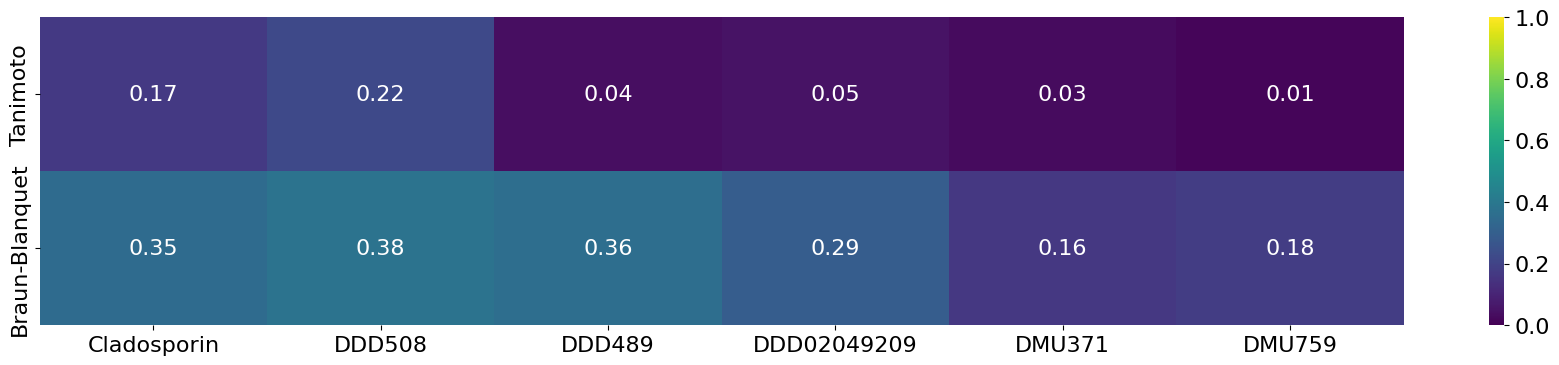

In [42]:
# @title Heatmap 2D
plt.figure(figsize=(22, 4))
sns.heatmap(sim_matrix_tt_bb, annot=True, cmap="viridis", fmt=".2f", vmin=0, vmax=1)
plt.show()

In [43]:
# @title Show molecules in 3D

for name, smi in smiles_dict.items():
    mol = Chem.AddHs(Chem.MolFromSmiles(smi))
    AllChem.EmbedMolecule(mol, randomSeed=1)
    AllChem.UFFOptimizeMolecule(mol)

    print(name)

    view = py3Dmol.view(width=400, height=300)
    view.addModel(Chem.MolToMolBlock(mol), 'sdf')
    view.setStyle({'stick': {'radius': 0.15}})
    view.zoomTo()
    view.show()


CID12


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Cladosporin


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DDD508


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DDD489


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DDD02049209


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DMU371


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

DMU759


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Align

In [44]:
# @title Prepare molecules for 3D Aligment
# Colors
colors = {
    "CID12": "magenta",
    "Cladosporin": "cyan",
    "DDD508": "green",
    "DDD489": "orange",
    "DDD02049209": "blue",
    "DMU371" : "yellow",
    "DMU759" : "red"
}

# 3D mols
mols = {}
for name, smi in smiles_dict.items():
    mol = Chem.AddHs(Chem.MolFromSmiles(smi))
    AllChem.EmbedMolecule(mol, randomSeed=1)
    mol_c = Chem.Mol(mol)
    rdMolTransforms.CanonicalizeConformer(mol_c.GetConformer())
    mols[name] = mol_c

ref = mols["CID12"]

In [45]:
# @title CID 12 (magenta) vs Cladosporin (cyan)

ref = mols["CID12"]
target = "Cladosporin"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

o3a = rdMolAlign.GetO3A(mol_tar, mol_ref)
o3a.Align()
tversky_cladosporin = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_cladosporin)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()


Tversky (O3A): 0.544066761652758


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [46]:
# @title CID 12 (magenta) vs DDD508 (green)

target = "DDD508"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

rdMolAlign.GetO3A(mol_tar, mol_ref).Align()
tversky_DDD508 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DDD508)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()


Tversky (O3A): 0.5466117558966679


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [47]:
# @title CID 12 (magenta) vs DDD508 (orange)

target = "DDD489"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

rdMolAlign.GetO3A(mol_tar, mol_ref).Align()
tversky_DDD489 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DDD489)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()


Tversky (O3A): 0.5032379004771643


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [48]:
# @title CID 12 (magenta) vs DDD02049209 (blue)
target = "DDD02049209"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

rdMolAlign.GetO3A(mol_tar, mol_ref).Align()
tversky_DDD02049209 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DDD02049209)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()


Tversky (O3A): 0.5898318042813455


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [49]:
# @title CID 12 (magenta) vs DMU371 (yellow)
target = "DMU371"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

o3a = rdMolAlign.GetO3A(mol_tar, mol_ref)
o3a.Align()
tversky_DMU371 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DMU371)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()

Tversky (O3A): 0.710272536687631


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [50]:
# @title CID 12 (magenta) vs DMU759 (red)
target = "DMU759"

mol_ref = Chem.Mol(ref)
mol_tar = Chem.Mol(mols[target])

o3a = rdMolAlign.GetO3A(mol_tar, mol_ref)
o3a.Align()
tversky_DMU759 = rdShapeHelpers.ShapeTverskyIndex(mol_ref, mol_tar, 0, 1)

print("Tversky (O3A):", tversky_DMU759)

view = py3Dmol.view(width=600, height=400)

view.addModel(Chem.MolToMolBlock(mol_ref), 'sdf')
view.setStyle({'model': 0}, {'stick': {'color': colors["CID12"]}})

view.addModel(Chem.MolToMolBlock(mol_tar), 'sdf')
view.setStyle({'model': 1}, {'stick': {'color': colors[target]}})

view.zoomTo()
view.show()

Tversky (O3A): 0.6282002292701566


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [51]:
# @title CID 12 (magenta) vs all molecules

view = py3Dmol.view(width=700, height=500)

for i, name in enumerate(mols):
    mol = Chem.Mol(mols[name])
    if name != "CID12":
        rdMolAlign.GetO3A(mol, ref).Align()

    view.addModel(Chem.MolToMolBlock(mol), 'sdf')
    view.setStyle(
        {'model': i},
        {'stick': {'color': colors[name], 'opacity': 0.6 if name != "CID12" else 1.0}}
    )

view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [52]:
# @title Tversky scores

# Collect scores
tversky_scores = {
    "Cladosporin": tversky_cladosporin,
    "DDD508": tversky_DDD508,
    "DDD489": tversky_DDD489,
    "DDD02049209": tversky_DDD02049209,
    "DMU371" : tversky_DMU371,
    "DMU759" : tversky_DMU759
}

# Interpretation function
def interpret_tversky(score):
    if score >= 0.75:
        return "High similarity"
    elif score >= 0.60:
        return "Moderate–high similarity"
    elif score >= 0.45:
        return "Moderate similarity"
    else:
        return "Low similarity"

# Build table
df_tversky = pd.DataFrame.from_dict(
    tversky_scores, orient="index", columns=["Tversky index"]
)

df_tversky["Interpretation"] = df_tversky["Tversky index"].apply(interpret_tversky)

# Optional: round for readability
df_tversky["Tversky index"] = df_tversky["Tversky index"].round(3)

df_tversky


,Tversky index,Interpretation
Cladosporin,0.544,Moderate similarity
DDD508,0.547,Moderate similarity
DDD489,0.503,Moderate similarity
DDD02049209,0.590,Moderate similarity
DMU371,0.710,Moderate–high similarity
DMU759,0.628,Moderate–high similarity


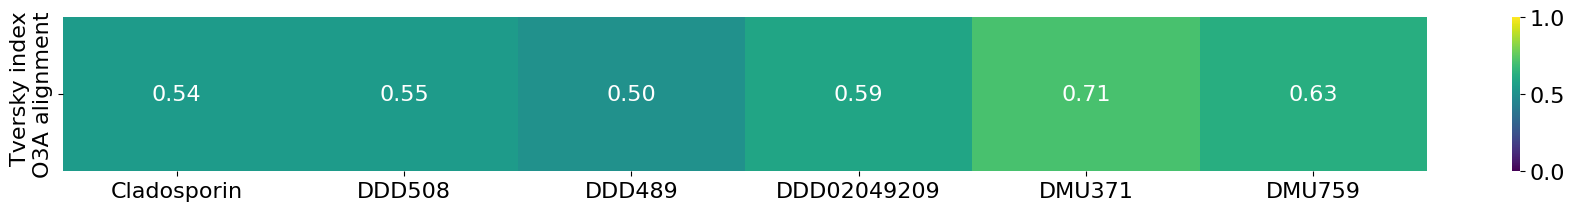

In [53]:
# @title Heaatmap 3D

ref_name = "Tversky index\nO3A alignment"
sim_matrix = pd.DataFrame([tversky_scores], index=[ref_name])

plt.figure(figsize=(22, 2))
sns.heatmap(
    sim_matrix,
    annot=True,
    cmap="viridis",
    fmt=".2f",
    vmin=0,
    vmax=1
)

plt.show()


Tversky scores shows:
- **Partial overlap** (shared core with divergent regions) with Cladosporin, DDD508, DDD489 and DDD02049209.
- **Substantial overlap** (with minor structural differences) with DMU371, DMU759.